In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import Map
from geopy.geocoders import Nominatim
import time
import requests
from folium.plugins import HeatMap
import seaborn as sns

In [90]:
!unzip /content/data-test-main.zip

Archive:  /content/data-test-main.zip
3a9ebce1ee6e7a14fbedf482a3a1cb701bffcee9
replace data-test-main/all_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Read data

In [91]:
data_df = pd.read_csv("/content/data-test-main/all_data.csv")

In [92]:
data_df.shape

(186850, 6)

In [93]:
data_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


## Data clearning

### Detect the number of rows that contains NaN

In [94]:
num_nan_rows = int(data_df.isna().any(axis=1).sum())


In [95]:
num_nan_rows

545

The number of rows that have NaN is negligeable compared to the total so we'll not consider them and delete them

In [96]:
data_df_cleaned = data_df.dropna()

In [97]:
data_df_cleaned

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"
...,...,...,...,...,...,...
186845,259353,AAA Batteries (4-pack),3,2.99,09/17/19 20:56,"840 Highland St, Los Angeles, CA 90001"
186846,259354,iPhone,1,700,09/01/19 16:00,"216 Dogwood St, San Francisco, CA 94016"
186847,259355,iPhone,1,700,09/23/19 07:39,"220 12th St, San Francisco, CA 94016"
186848,259356,34in Ultrawide Monitor,1,379.99,09/19/19 17:30,"511 Forest St, San Francisco, CA 94016"


We'll consider only the 2 products mentionned AAA Batteries (4-pack) and Thinkpad laptop

In [98]:
data_df_cleaned["Product"].value_counts()

,count
Product,
USB-C Charging Cable,21903
Lightning Charging Cable,21658
AAA Batteries (4-pack),20641
AA Batteries (4-pack),20577
Wired Headphones,18882
Apple Airpods Headphones,15549
Bose SoundSport Headphones,13325
27in FHD Monitor,7507
iPhone,6842


In [99]:
data_df_cleaned = data_df_cleaned[data_df_cleaned["Product"].isin(["AAA Batteries (4-pack)","ThinkPad Laptop"])]

In [100]:
 data_df_cleaned["city"] = data_df_cleaned["Purchase Address"].str.split(",").str[1]
 data_df_cleaned["state"] = "("+data_df_cleaned["Purchase Address"].str.split(",").str[2].str[:3]+")"

/tmp/ipython-input-2900836089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["city"] = data_df_cleaned["Purchase Address"].str.split(",").str[1]
/tmp/ipython-input-2900836089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["state"] = "("+data_df_cleaned["Purchase Address"].str.split(",").str[2].str[:3]+")"


In [101]:
data_df_cleaned[["city","state"]]

,city,state
20,New York City,( NY)
28,Portland,( OR)
32,San Francisco,( CA)
45,San Francisco,( CA)
54,Boston,( MA)
...,...,...
186829,Boston,( MA)
186835,San Francisco,( CA)
186836,San Francisco,( CA)
186840,Dallas,( TX)


In [102]:
data_df_cleaned["zone_commande"]= data_df_cleaned["city"] + data_df_cleaned["state"]

/tmp/ipython-input-2212933191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["zone_commande"]= data_df_cleaned["city"] + data_df_cleaned["state"]


In [103]:
data_df_cleaned["zone_commande"].unique()

array([' New York City( NY)', ' Portland( OR)', ' San Francisco( CA)',
       ' Boston( MA)', ' Dallas( TX)', ' Los Angeles( CA)',
       ' Austin( TX)', ' Seattle( WA)', ' Portland( ME)', ' Atlanta( GA)'],
      dtype=object)

## Data visualisation

### Geographic visualisation

In [104]:
## get the longitude and the latitude
geolocator = Nominatim(user_agent="geo_visualization")

def get_coordinates(city_state):
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": city_state,
        "format": "json",
        "limit": 1
    }
    response = requests.get(url, params=params, headers={"User-Agent": "Mozilla/5.0"})
    data = response.json()

    if len(data) > 0:
        return float(data[0]["lat"]), float(data[0]["lon"])



    else:
        return None, None

In [105]:
coords = [get_coordinates(loc.strip()) for loc in data_df_cleaned["zone_commande"].unique()]

In [106]:
coords

[(40.7127281, -74.0060152),
 (45.5202471, -122.674194),
 (37.7792588, -122.4193286),
 (42.3554334, -71.060511),
 (32.7762719, -96.7968559),
 (34.0536909, -118.242766),
 (30.2711286, -97.7436995),
 (47.6038321, -122.330062),
 (43.6634708, -70.2584907),
 (33.7544657, -84.3898151)]

In [107]:
coords_mapping = dict(zip(data_df_cleaned["zone_commande"].unique(), coords))

In [108]:
data_df_cleaned["lat"] = data_df_cleaned["zone_commande"].map(lambda x: coords_mapping[x][0] if coords_mapping[x] else None)
data_df_cleaned["lon"] = data_df_cleaned["zone_commande"].map(lambda x: coords_mapping[x][1] if coords_mapping[x] else None)

/tmp/ipython-input-1081114749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["lat"] = data_df_cleaned["zone_commande"].map(lambda x: coords_mapping[x][0] if coords_mapping[x] else None)
/tmp/ipython-input-1081114749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["lon"] = data_df_cleaned["zone_commande"].map(lambda x: coords_mapping[x][1] if coords_mapping[x] else None)


In [109]:
data_df_cleaned[["lat","lon"]]

,lat,lon
20,40.712728,-74.006015
28,45.520247,-122.674194
32,37.779259,-122.419329
45,37.779259,-122.419329
54,42.355433,-71.060511
...,...,...
186829,42.355433,-71.060511
186835,37.779259,-122.419329
186836,37.779259,-122.419329
186840,32.776272,-96.796856


In [110]:
map_center = [data_df_cleaned['lat'].mean(), data_df_cleaned['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=2)
for idx, row in data_df_cleaned.iterrows():
    if pd.notna(row['lat']) and pd.notna(row['lon']):
        folium.Marker([row['lat'], row['lon']], popup=row['zone_commande']).add_to(m)

heat_data = data_df_cleaned[['lat','lon']].dropna().values.tolist()
HeatMap(heat_data).add_to(m)

In [112]:
# the visualisation of the map always crash the notebook
m

In [ ]:
data_df_cleaned['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

# Extraire le mois pour regrouper par saison
data_df_cleaned["Month"] = data_df_cleaned['date'].dt.strftime('%b')
data_df_cleaned["Year"] = data_df_cleaned["Order Date"]

In [151]:
data_df_cleaned["Quantity Ordered"] = data_df_cleaned["Quantity Ordered"].apply(lambda x: int(x))

/tmp/ipython-input-982316658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["Quantity Ordered"] = data_df_cleaned["Quantity Ordered"].apply(lambda x: int(x))


### Saison visualisation (according to the month)

In [152]:
data_df_cleaned.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,city,state,zone_commande,lat,lon,year,month,month_num
20,176575,AAA Batteries (4-pack),1,2.99,2019-04-27 00:30:00,"433 Hill St, New York City, NY 10001",New York City,( NY),New York City( NY),40.712728,-74.006015,2019,Apr,4
28,176583,AAA Batteries (4-pack),2,2.99,2019-04-20 12:00:00,"146 Jackson St, Portland, OR 97035",Portland,( OR),Portland( OR),45.520247,-122.674194,2019,Apr,4
32,176586,AAA Batteries (4-pack),2,2.99,2019-10-04 17:00:00,"365 Center St, San Francisco, CA 94016",San Francisco,( CA),San Francisco( CA),37.779259,-122.419329,2019,Oct,10
45,176598,AAA Batteries (4-pack),2,2.99,2019-04-21 20:33:00,"294 Park St, San Francisco, CA 94016",San Francisco,( CA),San Francisco( CA),37.779259,-122.419329,2019,Apr,4
54,176607,AAA Batteries (4-pack),2,2.99,2019-04-18 12:11:00,"689 10th St, Boston, MA 02215",Boston,( MA),Boston( MA),42.355433,-71.060511,2019,Apr,4


In [153]:
data_df_cleaned['Order Date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)
data_df_cleaned['year'] = data_df_cleaned['Order Date'].dt.year
data_df_cleaned['month'] = data_df_cleaned['Order Date'].dt.strftime('%b')   # Month names
data_df_cleaned['month_num'] = data_df_cleaned['Order Date'].dt.month

/tmp/ipython-input-809167613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned['Order Date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)
/tmp/ipython-input-809167613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned['year'] = data_df_cleaned['Order Date'].dt.year
/tmp/ipython-input-809167613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

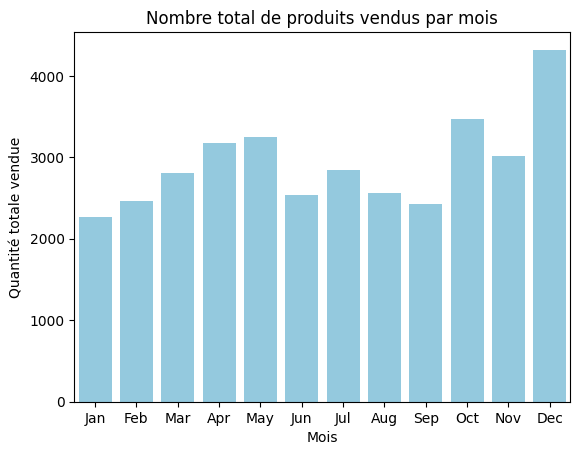

In [154]:
monthly_sales = data_df_cleaned.groupby(['month_num','month'])['Quantity Ordered'].sum().reset_index()
monthly_sales = monthly_sales.sort_values('month_num')

plt.figure()
sns.barplot(data=monthly_sales, x='month', y='Quantity Ordered', color='skyblue')
plt.title("Nombre total de produits vendus par mois")
plt.xlabel("Mois")
plt.ylabel("Quantité totale vendue")
plt.show()

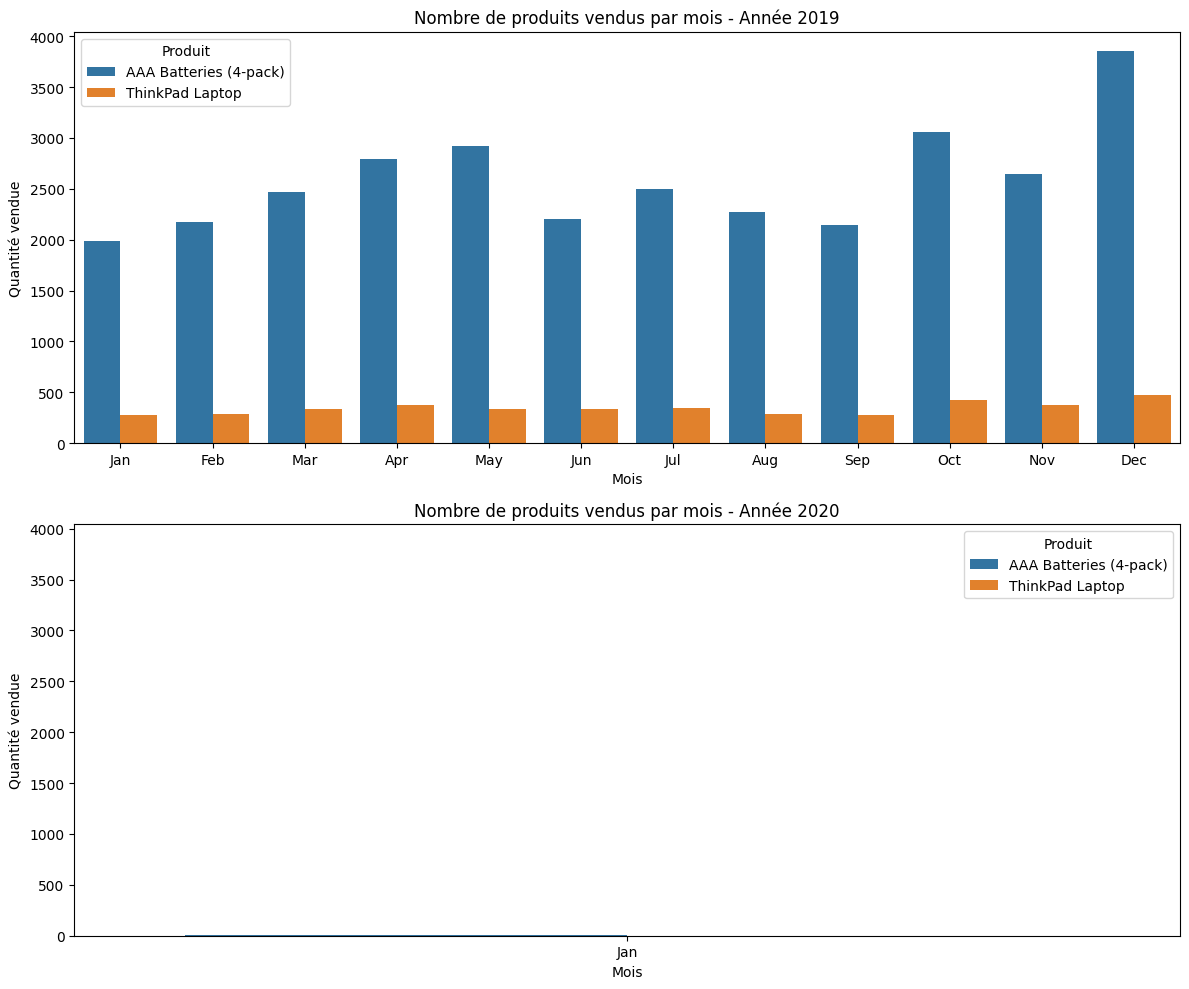

In [156]:
years = sorted(data_df_cleaned['year'].unique())
num_years = len(years)

# Create subplots
fig, axes = plt.subplots(num_years, 1, figsize=(12, 5*num_years), sharey=True)

if num_years == 1:
    axes = [axes]  # Make it iterable if only one year

for ax, year in zip(axes, years):
    # Filter data for the year
    df_year = data_df_cleaned[data_df_cleaned['year'] == year]

    # Aggregate quantity sold per product per month
    monthly_sales = df_year.groupby(['month_num','month','Product'])['Quantity Ordered'].sum().reset_index()

    # Sort by month number to ensure chronological order
    monthly_sales = monthly_sales.sort_values('month_num')

    # Plot barplot
    sns.barplot(
        data=monthly_sales,
        x='month',
        y='Quantity Ordered',
        hue='Product',
        ax=ax
    )
    ax.set_title(f"Nombre de produits vendus par mois - Année {year}")
    ax.set_xlabel("Mois")
    ax.set_ylabel("Quantité vendue")
    ax.legend(title="Produit")

plt.tight_layout()
plt.show()

## Feature Engineering

In [157]:
monthly_sales = data_df_cleaned.groupby(['Product','year','month'])['Quantity Ordered'].sum().reset_index()

# Map month name to month number
month_map = {
    'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
    'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12
}
monthly_sales['month_num'] = monthly_sales['month'].map(month_map)

# Now create datetime using year and month number
monthly_sales['ds'] = pd.to_datetime(dict(year=monthly_sales['year'], month=monthly_sales['month_num'], day=1))

# Rename target column for Prophet
monthly_sales.rename(columns={'Quantity Ordered':'y'}, inplace=True)

monthly_sales.sort_values(['Product','ds'], inplace=True)
monthly_sales.head()

,Product,year,month,y,month_num,ds
4,AAA Batteries (4-pack),2019,Jan,1987,1,2019-01-01
3,AAA Batteries (4-pack),2019,Feb,2177,2,2019-02-01
7,AAA Batteries (4-pack),2019,Mar,2469,3,2019-03-01
0,AAA Batteries (4-pack),2019,Apr,2796,4,2019-04-01
8,AAA Batteries (4-pack),2019,May,2919,5,2019-05-01


In [167]:
data_df_cleaned['order date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)

monthly_sales = data_df_cleaned.groupby(
    ['Product','zone_commande','year','month_num']
)['Quantity Ordered'].sum().reset_index()

monthly_sales.sort_values(['Product','zone_commande','year','month_num'], inplace=True)

/tmp/ipython-input-4249577697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned['order date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)


In [168]:
monthly_sales

,Product,zone_commande,year,month_num,Quantity Ordered
0,AAA Batteries (4-pack),Atlanta( GA),2019,1,134
1,AAA Batteries (4-pack),Atlanta( GA),2019,2,170
2,AAA Batteries (4-pack),Atlanta( GA),2019,3,186
3,AAA Batteries (4-pack),Atlanta( GA),2019,4,217
4,AAA Batteries (4-pack),Atlanta( GA),2019,5,237
...,...,...,...,...,...
240,ThinkPad Laptop,Seattle( WA),2019,8,16
241,ThinkPad Laptop,Seattle( WA),2019,9,25
242,ThinkPad Laptop,Seattle( WA),2019,10,33
243,ThinkPad Laptop,Seattle( WA),2019,11,33


## Model training

RMSE: 3.9544001396131327


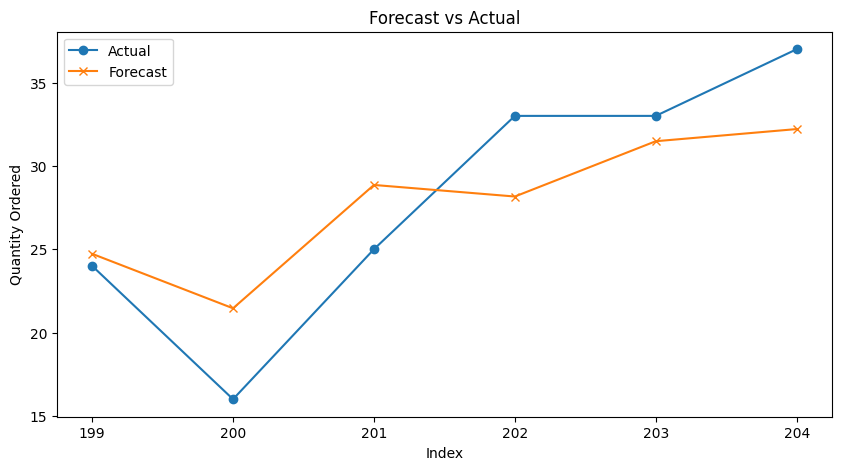

In [183]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Copy the dataframe
df = monthly_sales.copy()

# encode categorical feature
le_product = LabelEncoder()
le_zone = LabelEncoder()

df['product_enc'] = le_product.fit_transform(df['Product'])
df['zone_enc'] = le_zone.fit_transform(df['zone_commande'])



df = df.sort_values(['Product','zone_commande','month_num'])
df['lag_1'] = df.groupby(['Product','zone_commande'])['Quantity Ordered'].shift(1)
df['lag_2'] = df.groupby(['Product','zone_commande'])['Quantity Ordered'].shift(2)

# Rolling mean over last 3 months per product and zone
df['rolling_3'] = df.groupby(['Product','zone_commande'])['Quantity Ordered'].transform(lambda x: x.rolling(3).mean())


df = df.dropna().reset_index(drop=True)
df = df.drop(columns=['year'])

# ---------------------------
# Step 6: Train/test split
# ---------------------------
df = df.sort_values(['Product','zone_commande','month_num'])
train = df.iloc[:-6]   # last 6 months as test
test = df.iloc[-6:]

features = ['lag_1','lag_2','rolling_3','product_enc','zone_enc']
target = 'Quantity Ordered'

# ---------------------------
# Step 7: Train XGBoost model
# ---------------------------
model = XGBRegressor(n_estimators=200, learning_rate=0.1)
model.fit(train[features], train[target])

# Predict
pred = model.predict(test[features])

# Evaluate
rmse = np.sqrt(mean_squared_error(test[target], pred))
print("RMSE:", rmse)

# ---------------------------
# Step 8: Visualize forecasts
# ---------------------------
plt.figure(figsize=(10,5))
plt.plot(test.index, test[target], marker='o', label='Actual')
plt.plot(test.index, pred, marker='x', label='Forecast')
plt.xlabel("Index")
plt.ylabel("Quantity Ordered")
plt.title("Forecast vs Actual")
plt.legend()
plt.show()


In [185]:
import joblib
joblib.dump(model,"model.pkl")
joblib.dump(le_zone,"zone.pkl")
joblib.dump(le_product,"product.pkl")

['product.pkl']